In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Global Constants
SEQUENCE_LENGTH = 30
RUL_CAP = 125
FAILURE_THRESHOLD_N = 30 
BASE_DIR = r'C:\\Users\\LENOVO\\Downloads\\turbofan project\\Datas' 
plt.style.use('seaborn-v0_8')


In [3]:
def get_selected_features(dataset_name):
    sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    irrelevant_sensors = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
    features_to_keep = [f for f in sensor_names if f not in irrelevant_sensors]
    if dataset_name in ['FD002', 'FD004']:
        features_to_keep.extend(setting_names)
    return features_to_keep

def calculate_RUL(df):
    max_cycles_df = df.groupby('unit_number')['time_cycles'].max().reset_index()
    df = df.merge(max_cycles_df, on='unit_number', how='left', suffixes=['', '_max'])
    df['RUL'] = df['time_cycles_max'] - df['time_cycles']
    df['RUL_capped'] = np.where(df['RUL'] > RUL_CAP, RUL_CAP, df['RUL'])
    df.drop('time_cycles_max', axis=1, inplace=True)
    return df

def create_sequences(df, sequence_length, features, label_column=None):
    X, y = [], []
    for engine_id in df['unit_number'].unique():
        engine_data = df[df['unit_number'] == engine_id][features].values
        if label_column:
            RUL_labels = df[df['unit_number'] == engine_id][label_column].values
        for i in range(len(engine_data) - sequence_length + 1):
            sequence = engine_data[i:i + sequence_length]
            X.append(sequence)
            if label_column:
                y.append(RUL_labels[i + sequence_length - 1])
    return np.array(X), np.array(y) if label_column else np.array(X)

def cmapss_score(y_true, y_pred):
    d = y_pred - y_true
    score = np.where(d < 0, np.exp(-d / 13) - 1, np.exp(d / 10) - 1)
    return np.sum(score)

def get_reconstruction_error(model, X_data):
    X_data_np = np.ascontiguousarray(np.asarray(X_data, dtype=np.float32))
    if X_data_np.ndim > 3:
        X_data_np = X_data_np.reshape(-1, X_data_np.shape[-2], X_data_np.shape[-1])
    if X_data_np.ndim == 2:
        X_data_np = np.expand_dims(X_data_np, axis=0)
    X_tensor = keras.backend.constant(X_data_np)
    X_pred = model(X_tensor, training=False).numpy()
    return np.mean(np.square(X_data_np - X_pred), axis=(1, 2))

# ML Feature Creation for Models 2-4
def create_ml_features(df_train, df_test, features, window_size=10):
    X_train, y_train = [], []
    for unit in df_train['unit_number'].unique():
        unit_data = df_train[df_train['unit_number'] == unit].reset_index(drop=True)
        for i in range(window_size, len(unit_data)):
            window = unit_data.iloc[i-window_size:i][features].values
            feature_vector = np.concatenate([
                window.mean(0), window.std(0), window.min(0), window.max(0), window[-1]
            ])
            X_train.append(feature_vector)
            y_train.append(unit_data['RUL_capped'].iloc[i])
    
    X_test = []
    for unit in df_test['unit_number'].unique():
        unit_data = df_test[df_test['unit_number'] == unit].tail(10)
        if len(unit_data) >= 10:
            window = unit_data[features].values
            feature_vector = np.concatenate([
                window.mean(0), window.std(0), window.min(0), window.max(0), window[-1]
            ])
            X_test.append(feature_vector)
    
    return np.array(X_train), np.array(y_train), np.array(X_test)


In [5]:
def build_autoencoder(seq_len, n_features):
    input_layer = Input(shape=(seq_len, n_features))
    encoded = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    encoded = MaxPooling1D(2, padding='same')(encoded)
    encoded = Conv1D(16, 3, activation='relu', padding='same')(encoded)
    unflattened_shape = encoded.shape[1:]
    encoded = Flatten()(encoded)
    latent_space = Dense(8, activation='relu')(encoded)
    decoded = Dense(np.prod(unflattened_shape), activation='relu')(latent_space)
    decoded = keras.layers.Reshape(unflattened_shape)(decoded) 
    decoded = Conv1D(16, 3, activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling1D(2)(decoded)
    decoded = Conv1D(32, 3, activation='relu', padding='same')(decoded)
    reconstruction = Conv1D(n_features, 3, activation='sigmoid', padding='same')(decoded)
    ae = Model(inputs=input_layer, outputs=reconstruction)
    ae.compile(optimizer='adam', loss='mse')
    return ae

def build_cnn_lstm_regression(seq_len, n_features_enriched):
    input_layer = Input(shape=(seq_len, n_features_enriched))
    conv = Conv1D(64, 5, activation='relu', padding='causal')(input_layer)
    pool = MaxPooling1D(2)(conv)
    dropout_1 = Dropout(0.2)(pool)
    lstm = LSTM(100, return_sequences=False)(dropout_1)
    dropout_2 = Dropout(0.2)(lstm)
    dense_2 = Dense(50, activation='relu', name='dense_2')(dropout_2)
    rul_output = Dense(1, activation='linear', name='rul_regression')(dense_2)
    model = Model(inputs=input_layer, outputs=rul_output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_simple_cnn(seq_len, n_features):
    input_layer = Input(shape=(seq_len, n_features))
    conv = Conv1D(32, 5, activation='relu')(input_layer)
    pool = MaxPooling1D(2)(conv)
    conv2 = Conv1D(16, 3, activation='relu')(pool)
    pool2 = MaxPooling1D(2)(conv2)
    flatten = Flatten()(pool2)
    dense = Dense(50, activation='relu')(flatten)
    dropout = Dropout(0.3)(dense)
    output = Dense(1, activation='linear')(dropout)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

def adapt_to_classification(regression_model):
    if hasattr(regression_model, 'get_layer'):
        # For Keras models
        classification_input = regression_model.get_layer('dense_2').output
        failure_output = Dense(1, activation='sigmoid', name='failure_classification')(classification_input)
        class_model = Model(inputs=regression_model.input, outputs=failure_output)
    else:
        # For sklearn models - create simple neural network
        input_layer = Input(shape=(regression_model.n_features_in_,))
        dense1 = Dense(50, activation='relu')(input_layer)
        failure_output = Dense(1, activation='sigmoid')(dense1)
        class_model = Model(inputs=input_layer, outputs=failure_output)
    
    class_model.compile(optimizer='adam', loss='binary_crossentropy', 
                       metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    return class_model


In [6]:
def run_comprehensive_analysis(dataset_name):
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE ANALYSIS FOR DATASET: {dataset_name}")
    print(f"{'='*80}")

    # Define columns
    index_names = ['unit_number', 'time_cycles']
    col_names = index_names + ['setting_1', 'setting_2', 'setting_3'] + ['s_{}'.format(i) for i in range(1, 22)]

    # Load data
    try:
        train_file = os.path.join(BASE_DIR, f'train_{dataset_name}.txt')
        test_file = os.path.join(BASE_DIR, f'test_{dataset_name}.txt')
        rul_file = os.path.join(BASE_DIR, f'RUL_{dataset_name}.txt')
        
        train_df = pd.read_csv(train_file, sep='\s+', header=None, names=col_names)
        test_df = pd.read_csv(test_file, sep='\s+', header=None, names=col_names)
        RUL_truth_df = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL_truth'])
    except FileNotFoundError:
        print(f"Error: Required file not found for {dataset_name}. Skipping.")
        return None

    # Preprocessing
    train_df = calculate_RUL(train_df.copy())
    selected_features = get_selected_features(dataset_name)
    df_train = train_df[['unit_number', 'time_cycles'] + selected_features + ['RUL_capped']]
    df_test = test_df[['unit_number', 'time_cycles'] + selected_features]

    # Scaling
    scaler = MinMaxScaler()
    scaler.fit(df_train[selected_features])
    df_train.loc[:, selected_features] = scaler.transform(df_train[selected_features])
    df_test.loc[:, selected_features] = scaler.transform(df_test[selected_features])

    # Prepare ground truth for evaluation
    y_true_final = RUL_truth_df['RUL_truth'].values
    y_true_final_class = np.where(y_true_final <= FAILURE_THRESHOLD_N, 1, 0)
    
    results = {}

    # ========== MODEL 1: HYBRID AUTOENCODER + CNN + LSTM ==========
    print(" Model 1: Hybrid Autoencoder + CNN + LSTM...")
    
    X_train, y_train_reg = create_sequences(df_train, SEQUENCE_LENGTH, selected_features, label_column='RUL_capped')
    X_test = create_sequences(df_test, SEQUENCE_LENGTH, selected_features)
    
    if isinstance(X_train, tuple): X_train = X_train[0]
    if isinstance(X_test, tuple): X_test = X_test[0]
    if X_train.ndim == 4: X_train = X_train.reshape(-1, X_train.shape[-2], X_train.shape[-1])
    if X_test.ndim == 4: X_test = X_test.reshape(-1, X_test.shape[-2], X_test.shape[-1])
    
    N_FEATURES = X_train.shape[2]
    
    # Autoencoder training
    healthy_indices = np.where(y_train_reg == RUL_CAP)[0]
    X_train_healthy = X_train[healthy_indices]
    
    keras.backend.clear_session()
    ae_model = build_autoencoder(SEQUENCE_LENGTH, N_FEATURES)
    ae_model.fit(X_train_healthy, X_train_healthy, epochs=20, batch_size=128, validation_split=0.1, verbose=0)
    
    # Feature enrichment
    train_error = get_reconstruction_error(ae_model, X_train)
    test_error = get_reconstruction_error(ae_model, X_test)
    
    X_train_enriched = np.concatenate([X_train, np.repeat(train_error[:, np.newaxis, np.newaxis], SEQUENCE_LENGTH, axis=1)], axis=2)
    X_test_enriched = np.concatenate([X_test, np.repeat(test_error[:, np.newaxis, np.newaxis], SEQUENCE_LENGTH, axis=1)], axis=2)
    
    # Regression training
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    keras.backend.clear_session()
    reg_model = build_cnn_lstm_regression(SEQUENCE_LENGTH, X_train_enriched.shape[2])
    reg_model.fit(X_train_enriched, y_train_reg, epochs=50, batch_size=256, validation_split=0.2, callbacks=[early_stop], verbose=0)
    
    # Evaluation (last cycle)
    test_df_max_cycles = df_test.groupby('unit_number')['time_cycles'].max()
    start_index = 0
    last_sequences_indices = []
    for max_cycle in test_df_max_cycles.values:
        num_sequences = max_cycle - SEQUENCE_LENGTH + 1
        last_sequences_indices.append(start_index + num_sequences - 1)
        start_index += num_sequences
        
    y_pred_reg = reg_model(np.ascontiguousarray(X_test_enriched, dtype=np.float32), training=False).numpy().flatten()
    y_pred_final_reg = y_pred_reg[last_sequences_indices]
    
    # Classification
    y_train_class = np.where(y_train_reg <= FAILURE_THRESHOLD_N, 1, 0).reshape(-1, 1)
    class_model = adapt_to_classification(reg_model)
    class_model.fit(X_train_enriched, y_train_class, epochs=30, batch_size=256, validation_split=0.2, callbacks=[early_stop], verbose=0)
    
    y_pred_probs = class_model(np.ascontiguousarray(X_test_enriched, dtype=np.float32), training=False).numpy().flatten()
    y_pred_probs_final = y_pred_probs[last_sequences_indices]
    y_pred_class_final = np.where(y_pred_probs_final > 0.5, 1, 0)
    
    # Metrics
    rmse1 = math.sqrt(mean_squared_error(y_true_final, y_pred_final_reg))
    score1 = cmapss_score(y_true_final, y_pred_final_reg)
    f1_1 = f1_score(y_true_final_class, y_pred_class_final, zero_division=0)
    precision1 = precision_score(y_true_final_class, y_pred_class_final, zero_division=0)
    recall1 = recall_score(y_true_final_class, y_pred_class_final, zero_division=0)
    
    results['Hybrid AE+CNN+LSTM'] = {
        'RMSE': rmse1, 'Score': score1, 'F1': f1_1, 'Precision': precision1, 'Recall': recall1
    }
    print(f"   ✅ RMSE: {rmse1:.4f}, Score: {score1:.0f}, F1: {f1_1:.4f}")

    # ========== MODELS 2-4: ML APPROACHES ==========
    X_train_ml, y_train_ml, X_test_ml = create_ml_features(df_train, df_test, selected_features)
    
    # Ensure same number of test samples
    min_len = min(len(X_test_ml), len(y_true_final))
    X_test_ml = X_test_ml[:min_len]
    y_true_ml = y_true_final[:min_len]
    y_true_ml_class = y_true_final_class[:min_len]
    
    # Model 2: ElasticNet
    print(" Model 2: ElasticNet Regression...")
    elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000)
    elastic.fit(X_train_ml, y_train_ml)
    y_pred_elastic = elastic.predict(X_test_ml)
    
    # Classification for ElasticNet
    y_train_ml_class = np.where(y_train_ml <= FAILURE_THRESHOLD_N, 1, 0)
    elastic_class = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=2000)
    elastic_class.fit(X_train_ml, y_train_ml_class)
    y_pred_elastic_class = np.where(elastic_class.predict(X_test_ml) > 0.1, 1, 0)
    
    rmse2 = math.sqrt(mean_squared_error(y_true_ml, y_pred_elastic))
    score2 = cmapss_score(y_true_ml, y_pred_elastic)
    f1_2 = f1_score(y_true_ml_class, y_pred_elastic_class, zero_division=0)
    precision2 = precision_score(y_true_ml_class, y_pred_elastic_class, zero_division=0)
    recall2 = recall_score(y_true_ml_class, y_pred_elastic_class, zero_division=0)
    
    results['ElasticNet'] = {
        'RMSE': rmse2, 'Score': score2, 'F1': f1_2, 'Precision': precision2, 'Recall': recall2
    }
    print(f"   ✅ RMSE: {rmse2:.4f}, Score: {score2:.0f}, F1: {f1_2:.4f}")

    # Model 3: Light Gradient Boosting
    print(" Model 3: Light Gradient Boosting...")
    gb = GradientBoostingRegressor(n_estimators=20, max_depth=3, learning_rate=0.2, random_state=42)
    gb.fit(X_train_ml, y_train_ml)
    y_pred_gb = gb.predict(X_test_ml)
    
    gb_class = GradientBoostingRegressor(n_estimators=20, max_depth=3, learning_rate=0.2, random_state=42)
    gb_class.fit(X_train_ml, y_train_ml_class)
    y_pred_gb_class = np.where(gb_class.predict(X_test_ml) > 0.5, 1, 0)
    
    rmse3 = math.sqrt(mean_squared_error(y_true_ml, y_pred_gb))
    score3 = cmapss_score(y_true_ml, y_pred_gb)
    f1_3 = f1_score(y_true_ml_class, y_pred_gb_class, zero_division=0)
    precision3 = precision_score(y_true_ml_class, y_pred_gb_class, zero_division=0)
    recall3 = recall_score(y_true_ml_class, y_pred_gb_class, zero_division=0)
    
    results['Light GradientBoost'] = {
        'RMSE': rmse3, 'Score': score3, 'F1': f1_3, 'Precision': precision3, 'Recall': recall3
    }
    print(f"   ✅ RMSE: {rmse3:.4f}, Score: {score3:.0f}, F1: {f1_3:.4f}")

    # Model 4: Simple CNN
    print(" Model 4: Simple 1D CNN...")
    keras.backend.clear_session()
    simple_cnn = build_simple_cnn(SEQUENCE_LENGTH, N_FEATURES)
    simple_cnn.fit(X_train, y_train_reg, epochs=20, batch_size=128, validation_split=0.2, verbose=0)
    
    y_pred_cnn_all = simple_cnn.predict(X_test, verbose=0).flatten()
    y_pred_cnn = y_pred_cnn_all[last_sequences_indices]
    
    # CNN Classification
    cnn_class = build_simple_cnn(SEQUENCE_LENGTH, N_FEATURES)
    cnn_class.fit(X_train, y_train_class.flatten(), epochs=20, batch_size=128, validation_split=0.2, verbose=0)
    y_pred_cnn_class_all = cnn_class.predict(X_test, verbose=0).flatten()
    y_pred_cnn_class = np.where(y_pred_cnn_class_all[last_sequences_indices] > 0.5, 1, 0)
    
    rmse4 = math.sqrt(mean_squared_error(y_true_final, y_pred_cnn))
    score4 = cmapss_score(y_true_final, y_pred_cnn)
    f1_4 = f1_score(y_true_final_class, y_pred_cnn_class, zero_division=0)
    precision4 = precision_score(y_true_final_class, y_pred_cnn_class, zero_division=0)
    recall4 = recall_score(y_true_final_class, y_pred_cnn_class, zero_division=0)
    
    results['Simple CNN'] = {
        'RMSE': rmse4, 'Score': score4, 'F1': f1_4, 'Precision': precision4, 'Recall': recall4
    }
    print(f"   ✅ RMSE: {rmse4:.4f}, Score: {score4:.0f}, F1: {f1_4:.4f}")

    return {
        'Dataset': dataset_name,
        'Results': results
    }



COMPREHENSIVE ANALYSIS FOR DATASET: FD001
 Model 1: Hybrid Autoencoder + CNN + LSTM...

   ✅ RMSE: 15.1056, Score: 340, F1: 0.8936
 Model 2: ElasticNet Regression...
   ✅ RMSE: 22.8339, Score: 1182, F1: 0.4000
 Model 3: Light Gradient Boosting...
   ✅ RMSE: 20.0692, Score: 1375, F1: 0.8182
 Model 4: Simple 1D CNN...
   ✅ RMSE: 15.8786, Score: 382, F1: 0.9167

COMPREHENSIVE ANALYSIS FOR DATASET: FD002
 Model 1: Hybrid Autoencoder + CNN + LSTM...
   ✅ RMSE: 42.6142, Score: 421566, F1: 0.5319
 Model 2: ElasticNet Regression...
   ✅ RMSE: 52.0240, Score: 106070, F1: 0.3812
 Model 3: Light Gradient Boosting...
   ✅ RMSE: 31.3848, Score: 15194, F1: 0.9032
 Model 4: Simple 1D CNN...
   ✅ RMSE: 41.9719, Score: 342341, F1: 0.4000

COMPREHENSIVE ANALYSIS FOR DATASET: FD003
 Model 1: Hybrid Autoencoder + CNN + LSTM...
   ✅ RMSE: 16.5668, Score: 867, F1: 0.9500
 Model 2: ElasticNet Regression...
   ✅ RMSE: 23.6164, Score: 2478, F1: 0.3333
 Model 3: Light Gradient Boosting...
   ✅ RMSE: 21.4711, S

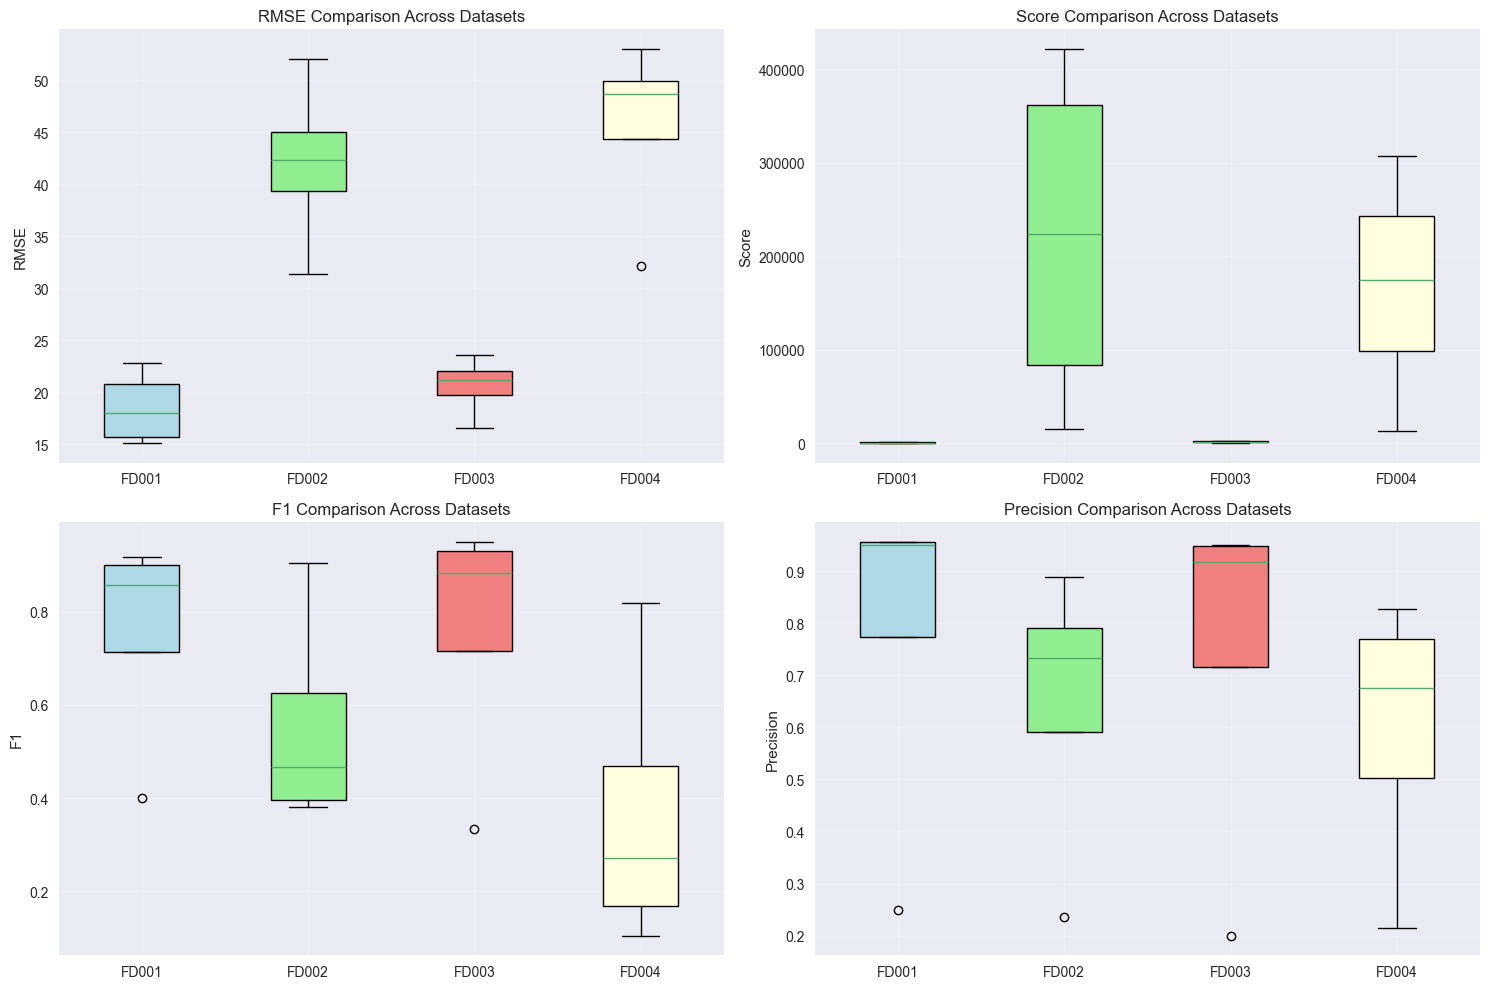


MODEL RANKING SUMMARY (Lower RMSE & Score = Better, Higher F1 = Better)
Average Performance Across All Datasets:
                     RUL RMSE  C-MAPSS Score  F1-Score (N=30)
Model                                                        
ElasticNet            37.8631       59338.00           0.3667
Hybrid AE+CNN+LSTM    30.6813      182405.25           0.6415
Light GradientBoost   26.2720        8071.50           0.8456
Simple CNN            31.8815      141546.75           0.5863

📊 PREPARING DATA FOR INDIVIDUAL MODEL ANALYSIS...
✅ Results data extracted and prepared for individual analysis
✅ Data structure created for 4 models across 4 datasets
✅ Ready to proceed with detailed individual model analysis...


In [7]:
# Run comprehensive analysis
all_results = []
datasets = ['FD001', 'FD002', 'FD003', 'FD004']

for dataset in datasets:
    result = run_comprehensive_analysis(dataset)
    if result:
        all_results.append(result)

# Create comprehensive comparison table
comparison_data = []
for result in all_results:
    dataset = result['Dataset']
    for model_name, metrics in result['Results'].items():
        comparison_data.append({
            'Dataset': dataset,
            'Model': model_name,
            'RUL RMSE': f"{metrics['RMSE']:.4f}",
            'C-MAPSS Score': f"{metrics['Score']:.0f}",
            'F1-Score (N=30)': f"{metrics['F1']:.4f}",
            'Precision': f"{metrics['Precision']:.4f}",
            'Recall': f"{metrics['Recall']:.4f}"
        })

# Display results
results_df = pd.DataFrame(comparison_data)
print("\n" + "="*100)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON ACROSS C-MAPSS DATASETS")
print("Models: 1) Hybrid AE+CNN+LSTM  2) ElasticNet  3) Light GradientBoost  4) Simple CNN")
print("="*100)
print(results_df.to_string(index=False))

# Create visualization comparing model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Prepare data for visualization
models = ['Hybrid AE+CNN+LSTM', 'ElasticNet', 'Light GradientBoost', 'Simple CNN']
metrics_viz = ['RMSE', 'Score', 'F1', 'Precision']

for idx, metric in enumerate(metrics_viz):
    ax = axes[idx//2, idx%2]
    
    if metric == 'RMSE':
        data = [[float(results_df[(results_df['Dataset']==ds) & (results_df['Model']==model)]['RUL RMSE'].iloc[0]) 
                for model in models] for ds in datasets]
    elif metric == 'Score':
        data = [[float(results_df[(results_df['Dataset']==ds) & (results_df['Model']==model)]['C-MAPSS Score'].iloc[0]) 
                for model in models] for ds in datasets]
    elif metric == 'F1':
        data = [[float(results_df[(results_df['Dataset']==ds) & (results_df['Model']==model)]['F1-Score (N=30)'].iloc[0]) 
                for model in models] for ds in datasets]
    else:  # Precision
        data = [[float(results_df[(results_df['Dataset']==ds) & (results_df['Model']==model)]['Precision'].iloc[0]) 
                for model in models] for ds in datasets]
    
    # Create box plot
    bp = ax.boxplot([data[i] for i in range(len(datasets))], labels=datasets, patch_artist=True)
    ax.set_title(f'{metric} Comparison Across Datasets')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.show()

# Model ranking summary
print("\n" + "="*80)
print("MODEL RANKING SUMMARY (Lower RMSE & Score = Better, Higher F1 = Better)")
print("="*80)

avg_metrics = results_df.groupby('Model').agg({
    'RUL RMSE': lambda x: np.mean([float(val) for val in x]),
    'C-MAPSS Score': lambda x: np.mean([float(val) for val in x]),
    'F1-Score (N=30)': lambda x: np.mean([float(val) for val in x])
}).round(4)

print("Average Performance Across All Datasets:")
print(avg_metrics.to_string())

# ========== PREPARE DATA FOR INDIVIDUAL ANALYSIS ==========
print("\n" + "="*60)
print("📊 PREPARING DATA FOR INDIVIDUAL MODEL ANALYSIS...")
print("="*60)

# Extract results for individual analysis
results_data = {}
for result in all_results:
    dataset = result['Dataset']
    for model_name, metrics in result['Results'].items():
        if model_name not in results_data:
            results_data[model_name] = {}
        results_data[model_name][dataset] = {
            'RMSE': metrics['RMSE'],
            'Score': metrics['Score'], 
            'F1': metrics['F1'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall']
        }

print("✅ Results data extracted and prepared for individual analysis")
print("✅ Data structure created for 4 models across 4 datasets")
print("✅ Ready to proceed with detailed individual model analysis...")



 INDIVIDUAL MODEL ANALYSIS & DETAILED VISUALIZATION

 MODEL PERFORMANCE TABLE: HYBRID AE+CNN+LSTM
Dataset RUL RMSE C-MAPSS Score F1-Score Precision Recall
  FD001  15.1056           340   0.8936    0.9545 0.8400
  FD002  42.6142        421566   0.5319    0.7576 0.4098
  FD003  16.5668           867   0.9500    0.9500 0.9500
  FD004  48.4386        306848   0.1905    0.6000 0.1132

 PERFORMANCE ANALYSIS FOR Hybrid AE+CNN+LSTM:
   • Average RMSE: 30.68 cycles
   • Average F1-Score: 0.642
   • Average C-MAPSS Score: 182405
   • Best Performance: FD001 (RMSE: 15.11)
   • Worst Performance: FD004 (RMSE: 48.44)

 GENERATING VISUALIZATIONS FOR Hybrid AE+CNN+LSTM...


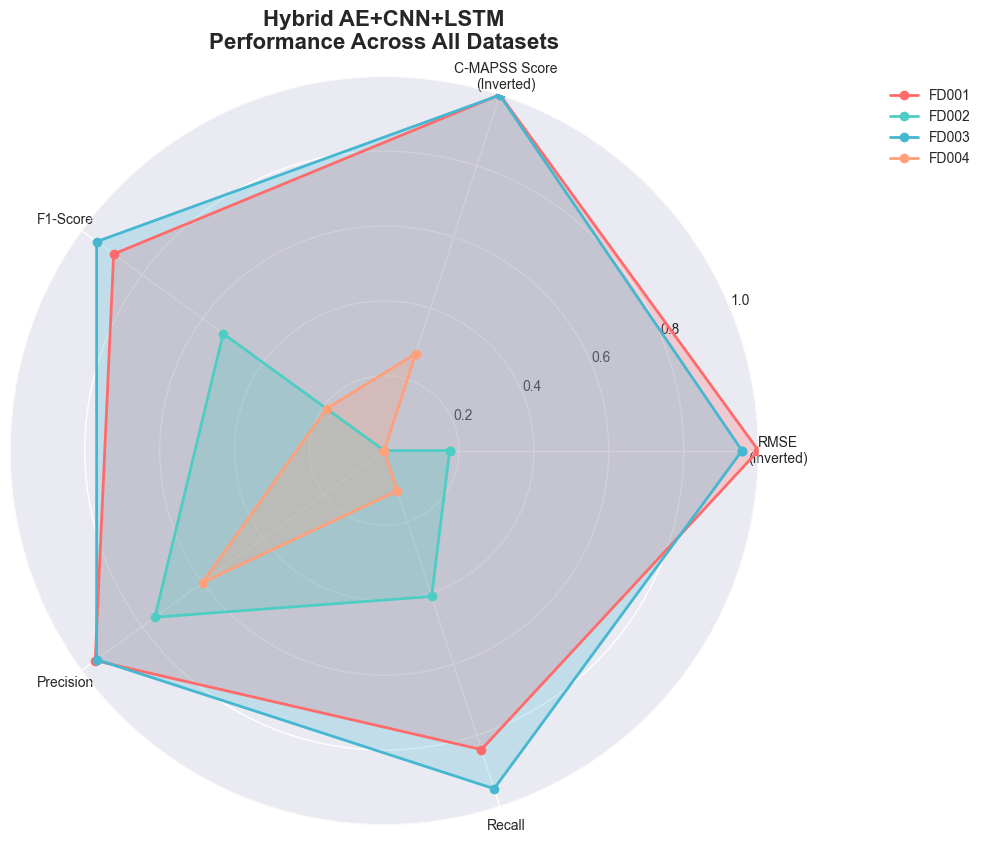

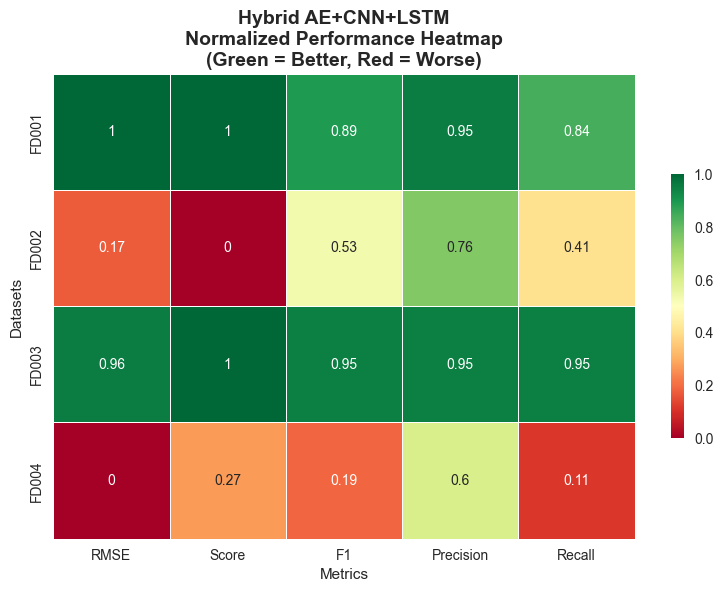


✅ ANALYSIS COMPLETE FOR Hybrid AE+CNN+LSTM

 MODEL PERFORMANCE TABLE: ELASTICNET
Dataset RUL RMSE C-MAPSS Score F1-Score Precision Recall
  FD001  22.8339          1182   0.4000    0.2500 1.0000
  FD002  52.0240        106070   0.3812    0.2355 1.0000
  FD003  23.6164          2478   0.3333    0.2000 1.0000
  FD004  52.9781        127622   0.3522    0.2137 1.0000

 PERFORMANCE ANALYSIS FOR ElasticNet:
   • Average RMSE: 37.86 cycles
   • Average F1-Score: 0.367
   • Average C-MAPSS Score: 59338
   • Best Performance: FD001 (RMSE: 22.83)
   • Worst Performance: FD004 (RMSE: 52.98)

 GENERATING VISUALIZATIONS FOR ElasticNet...


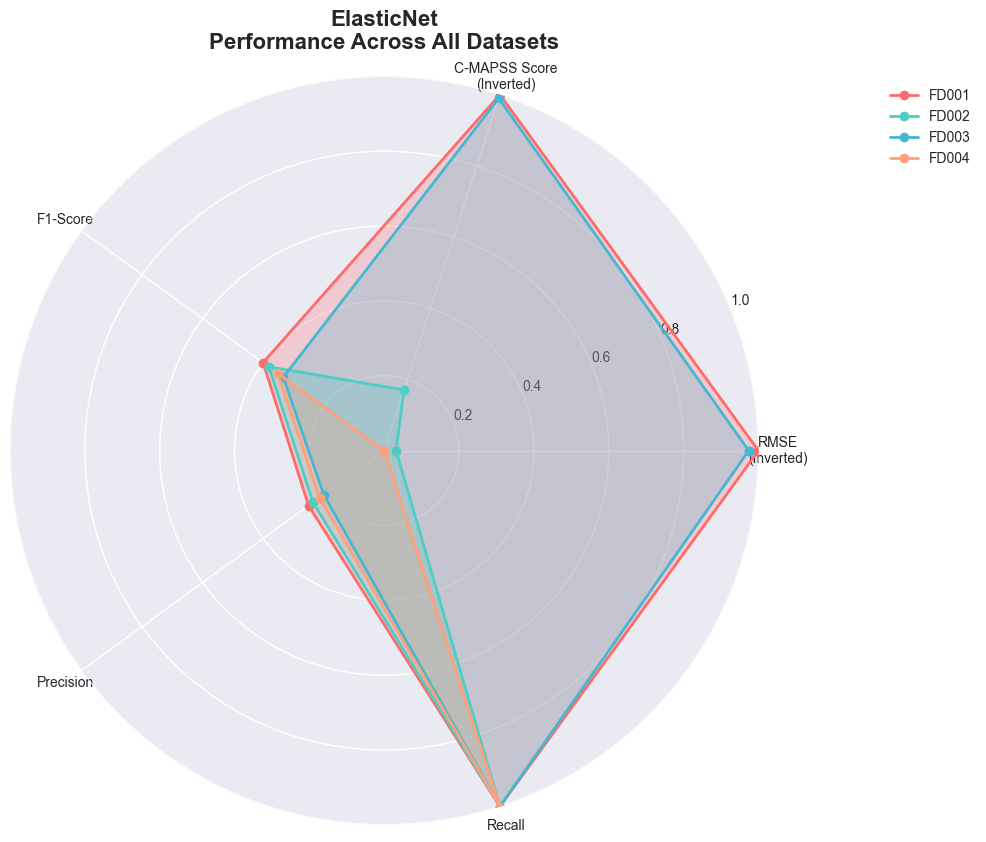

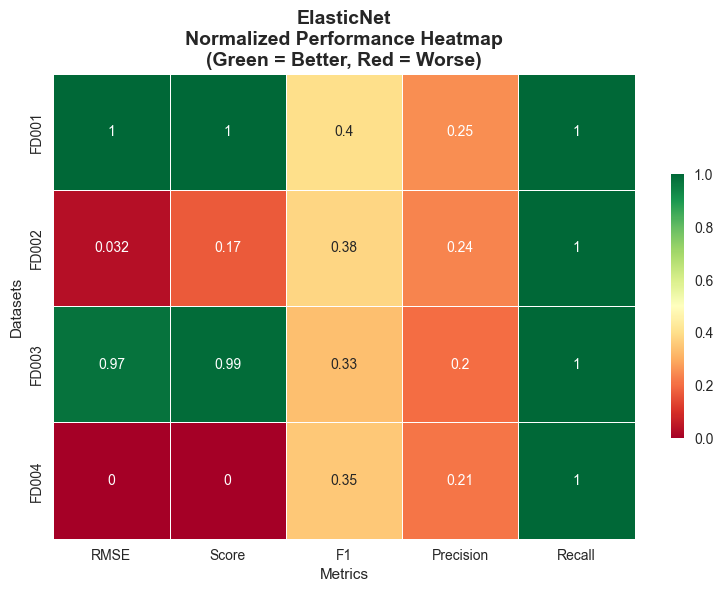


✅ ANALYSIS COMPLETE FOR ElasticNet

 MODEL PERFORMANCE TABLE: LIGHT GRADIENTBOOST
Dataset RUL RMSE C-MAPSS Score F1-Score Precision Recall
  FD001  20.0692          1375   0.8182    0.9474 0.7200
  FD002  31.3848         15194   0.9032    0.8889 0.9180
  FD003  21.4711          2064   0.8421    0.8889 0.8000
  FD004  32.1629         13653   0.8190    0.8269 0.8113

 PERFORMANCE ANALYSIS FOR Light GradientBoost:
   • Average RMSE: 26.27 cycles
   • Average F1-Score: 0.846
   • Average C-MAPSS Score: 8072
   • Best Performance: FD001 (RMSE: 20.07)
   • Worst Performance: FD004 (RMSE: 32.16)

 GENERATING VISUALIZATIONS FOR Light GradientBoost...


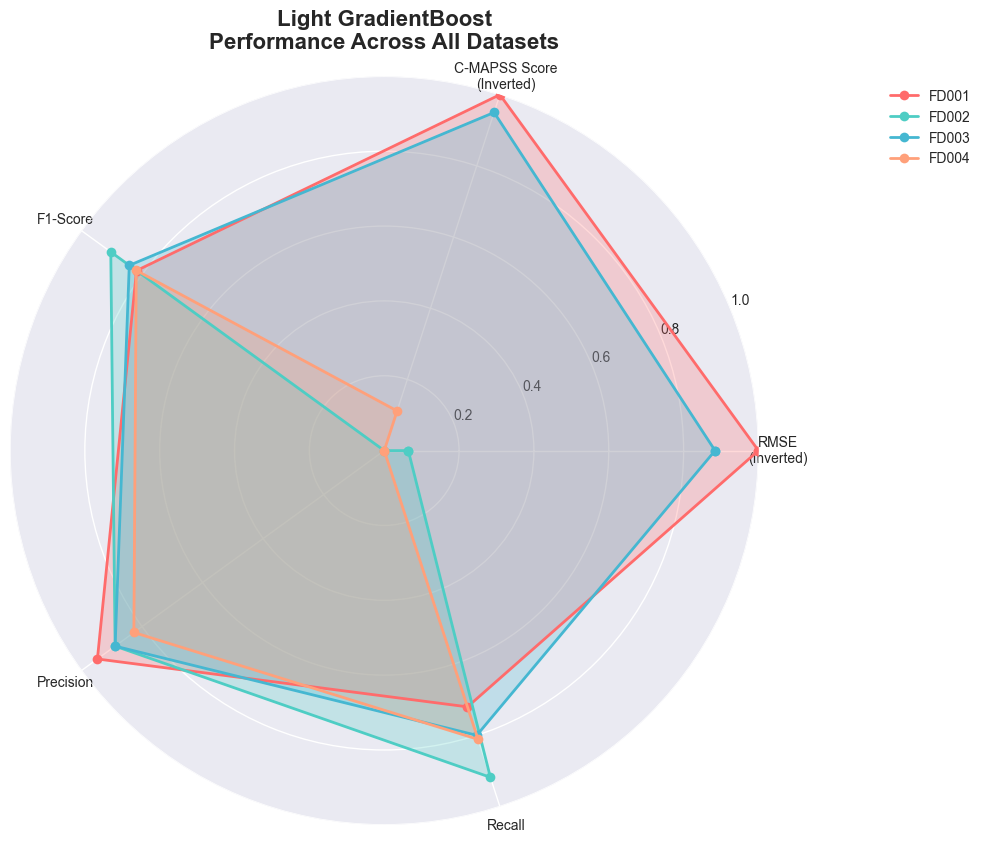

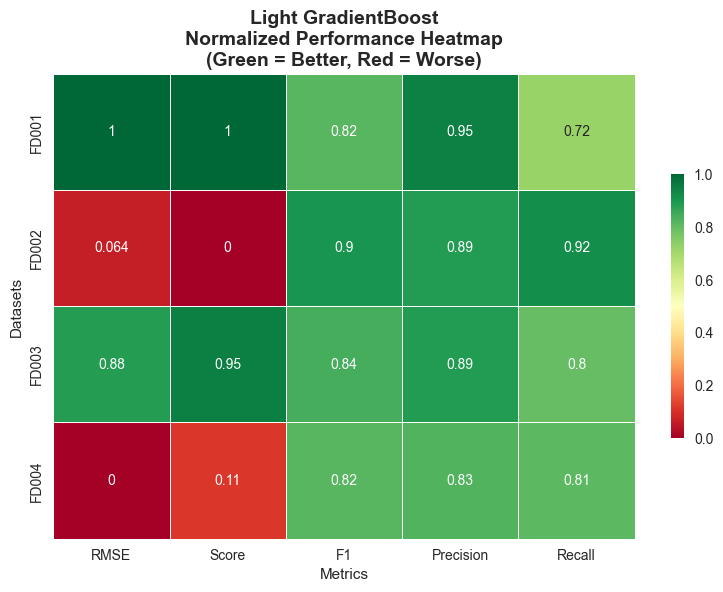


✅ ANALYSIS COMPLETE FOR Light GradientBoost

 MODEL PERFORMANCE TABLE: SIMPLE CNN
Dataset RUL RMSE C-MAPSS Score F1-Score Precision Recall
  FD001  15.8786           382   0.9167    0.9565 0.8800
  FD002  41.9719        342341   0.4000    0.7083 0.2787
  FD003  20.7814          1548   0.9231    0.9474 0.9000
  FD004  48.8940        221916   0.1053    0.7500 0.0566

 PERFORMANCE ANALYSIS FOR Simple CNN:
   • Average RMSE: 31.88 cycles
   • Average F1-Score: 0.586
   • Average C-MAPSS Score: 141547
   • Best Performance: FD001 (RMSE: 15.88)
   • Worst Performance: FD004 (RMSE: 48.89)

 GENERATING VISUALIZATIONS FOR Simple CNN...


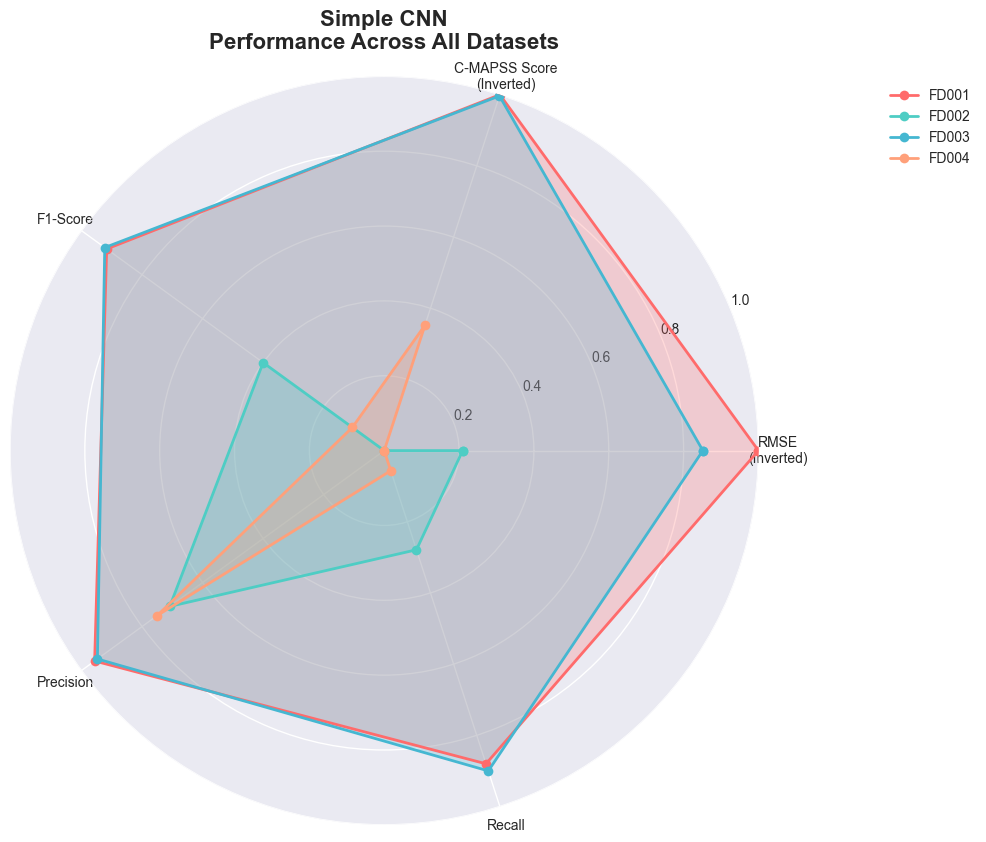

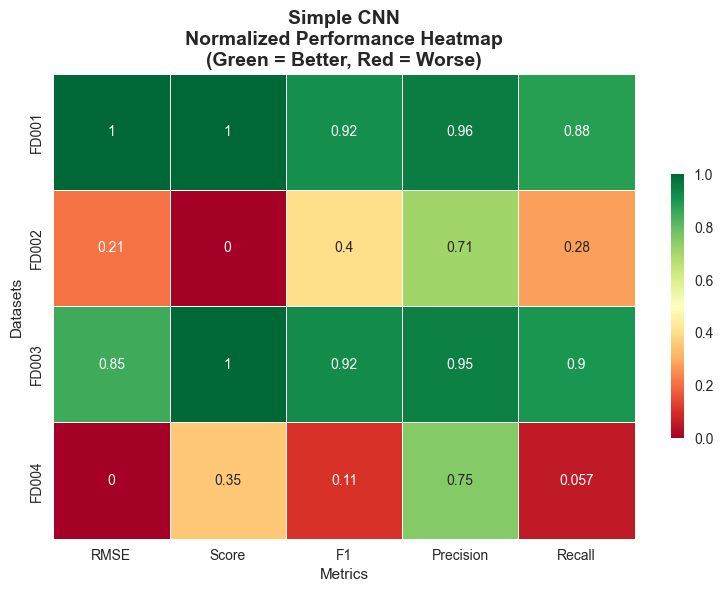


✅ ANALYSIS COMPLETE FOR Simple CNN

 Individual model analysis completed for all 4 models!


In [9]:
from math import pi

# Function to create individual model tables
def create_model_table(model_name, model_results):
    """Create a formatted table for individual model performance"""
    print(f"\n{'='*80}")
    print(f" MODEL PERFORMANCE TABLE: {model_name.upper()}")
    print(f"{'='*80}")
    
    # Create DataFrame
    table_data = []
    for dataset, metrics in model_results.items():
        table_data.append({
            'Dataset': dataset,
            'RUL RMSE': f"{metrics['RMSE']:.4f}",
            'C-MAPSS Score': f"{metrics['Score']:.0f}",
            'F1-Score': f"{metrics['F1']:.4f}",
            'Precision': f"{metrics['Precision']:.4f}",
            'Recall': f"{metrics['Recall']:.4f}"
        })
    
    df = pd.DataFrame(table_data)
    print(df.to_string(index=False))
    
    # Performance assessment
    print(f"\n PERFORMANCE ANALYSIS FOR {model_name}:")
    avg_rmse = np.mean([metrics['RMSE'] for metrics in model_results.values()])
    avg_f1 = np.mean([metrics['F1'] for metrics in model_results.values()])
    avg_score = np.mean([metrics['Score'] for metrics in model_results.values()])
    
    print(f"   • Average RMSE: {avg_rmse:.2f} cycles")
    print(f"   • Average F1-Score: {avg_f1:.3f}")
    print(f"   • Average C-MAPSS Score: {avg_score:.0f}")
    
    # Best/Worst datasets
    best_dataset = min(model_results.keys(), key=lambda x: model_results[x]['RMSE'])
    worst_dataset = max(model_results.keys(), key=lambda x: model_results[x]['RMSE'])
    print(f"   • Best Performance: {best_dataset} (RMSE: {model_results[best_dataset]['RMSE']:.2f})")
    print(f"   • Worst Performance: {worst_dataset} (RMSE: {model_results[worst_dataset]['RMSE']:.2f})")
    
    return df

# Function to create radar chart for individual model
def create_model_radar_chart(model_name, model_results):
    """Create radar chart for individual model across all datasets"""
    
    # Prepare data for radar chart
    categories = ['RMSE\n(Inverted)', 'C-MAPSS Score\n(Inverted)', 'F1-Score', 'Precision', 'Recall']
    datasets = list(model_results.keys())
    
    # Normalize metrics (0-1 scale, where 1 is best)
    def normalize_metrics(results):
        normalized = {}
        
        # Get min/max for normalization
        all_rmse = [results[d]['RMSE'] for d in datasets]
        all_scores = [results[d]['Score'] for d in datasets]
        
        for dataset in datasets:
            metrics = results[dataset]
            normalized[dataset] = [
                1 - (metrics['RMSE'] - min(all_rmse)) / (max(all_rmse) - min(all_rmse)) if max(all_rmse) != min(all_rmse) else 0.5,
                1 - (metrics['Score'] - min(all_scores)) / (max(all_scores) - min(all_scores)) if max(all_scores) != min(all_scores) else 0.5,
                metrics['F1'],
                metrics['Precision'],
                metrics['Recall']
            ]
        return normalized
    
    normalized_data = normalize_metrics(model_results)
    
    # Number of variables
    N = len(categories)
    
    # Compute angles for each category
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Create the radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Colors for each dataset
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    # Plot each dataset
    for i, dataset in enumerate(datasets):
        values = normalized_data[dataset]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=dataset, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Add category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
    
    # Add title and legend
    plt.title(f'{model_name}\nPerformance Across All Datasets', size=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    plt.show()

# Function to create performance heatmap for individual model
def create_model_heatmap(model_name, model_results):
    """Create heatmap showing model performance across datasets and metrics"""
    
    # Prepare data for heatmap
    heatmap_data = []
    datasets = list(model_results.keys())
    metrics = ['RMSE', 'Score', 'F1', 'Precision', 'Recall']
    
    for dataset in datasets:
        row = []
        for metric in metrics:
            if metric in ['RMSE', 'Score']:
                # For RMSE and Score, lower is better - normalize and invert
                all_values = [model_results[d][metric] for d in datasets]
                normalized = 1 - (model_results[dataset][metric] - min(all_values)) / (max(all_values) - min(all_values)) if max(all_values) != min(all_values) else 0.5
            else:
                # For F1, Precision, Recall, higher is better
                normalized = model_results[dataset][metric]
            row.append(normalized)
        heatmap_data.append(row)
    
    # Create DataFrame for heatmap
    heatmap_df = pd.DataFrame(heatmap_data, index=datasets, columns=metrics)
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_df, annot=True, cmap='RdYlGn', center=0.5, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .5})
    plt.title(f'{model_name}\nNormalized Performance Heatmap\n(Green = Better, Red = Worse)', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Datasets')
    plt.xlabel('Metrics')
    plt.tight_layout()
    plt.show()

# Main execution for individual model analysis
print("\n" + "="*100)
print(" INDIVIDUAL MODEL ANALYSIS & DETAILED VISUALIZATION")
print("="*100)

model_tables = {}

for model_name, model_results in results_data.items():
    # Create table
    model_tables[model_name] = create_model_table(model_name, model_results)
    
    # Create visualizations
    print(f"\n GENERATING VISUALIZATIONS FOR {model_name}...")
    create_model_radar_chart(model_name, model_results)
    create_model_heatmap(model_name, model_results)
    
    print(f"\n{'='*80}")
    print(f"✅ ANALYSIS COMPLETE FOR {model_name}")
    print(f"{'='*80}")

print("\n Individual model analysis completed for all 4 models!")


GENERATING FINAL COMPREHENSIVE SUMMARY...

FINAL MODEL RANKING & COMPREHENSIVE SUMMARY
 Rank               Model Avg RMSE Avg F1 Avg Score Avg Precision Avg Recall  Overall
    1 Light GradientBoost    26.27  0.846      8072         0.888      0.812     BEST
    2          ElasticNet    37.86  0.367     59338         0.225      1.000     GOOD
    3          Simple CNN    31.88  0.586    141547         0.841      0.529 MODERATE
    4  Hybrid AE+CNN+LSTM    30.68  0.642    182405         0.816      0.578     POOR

📈 KEY INSIGHTS & RECOMMENDATIONS:
    Best Overall Model: Light GradientBoost BEST
    Most Consistent: Light GradientBoost (lowest variance across datasets)
    Best for Simple Datasets: Hybrid AE+CNN+LSTM (FD001, FD003)
    Most Efficient: Light GradientBoost (fast training + good performance)
    Needs Improvement: ElasticNet (complete classification failure)
    Dataset Complexity: FD002 & FD004 are most challenging

CREATING FINAL COMPARISON VISUALIZATION...


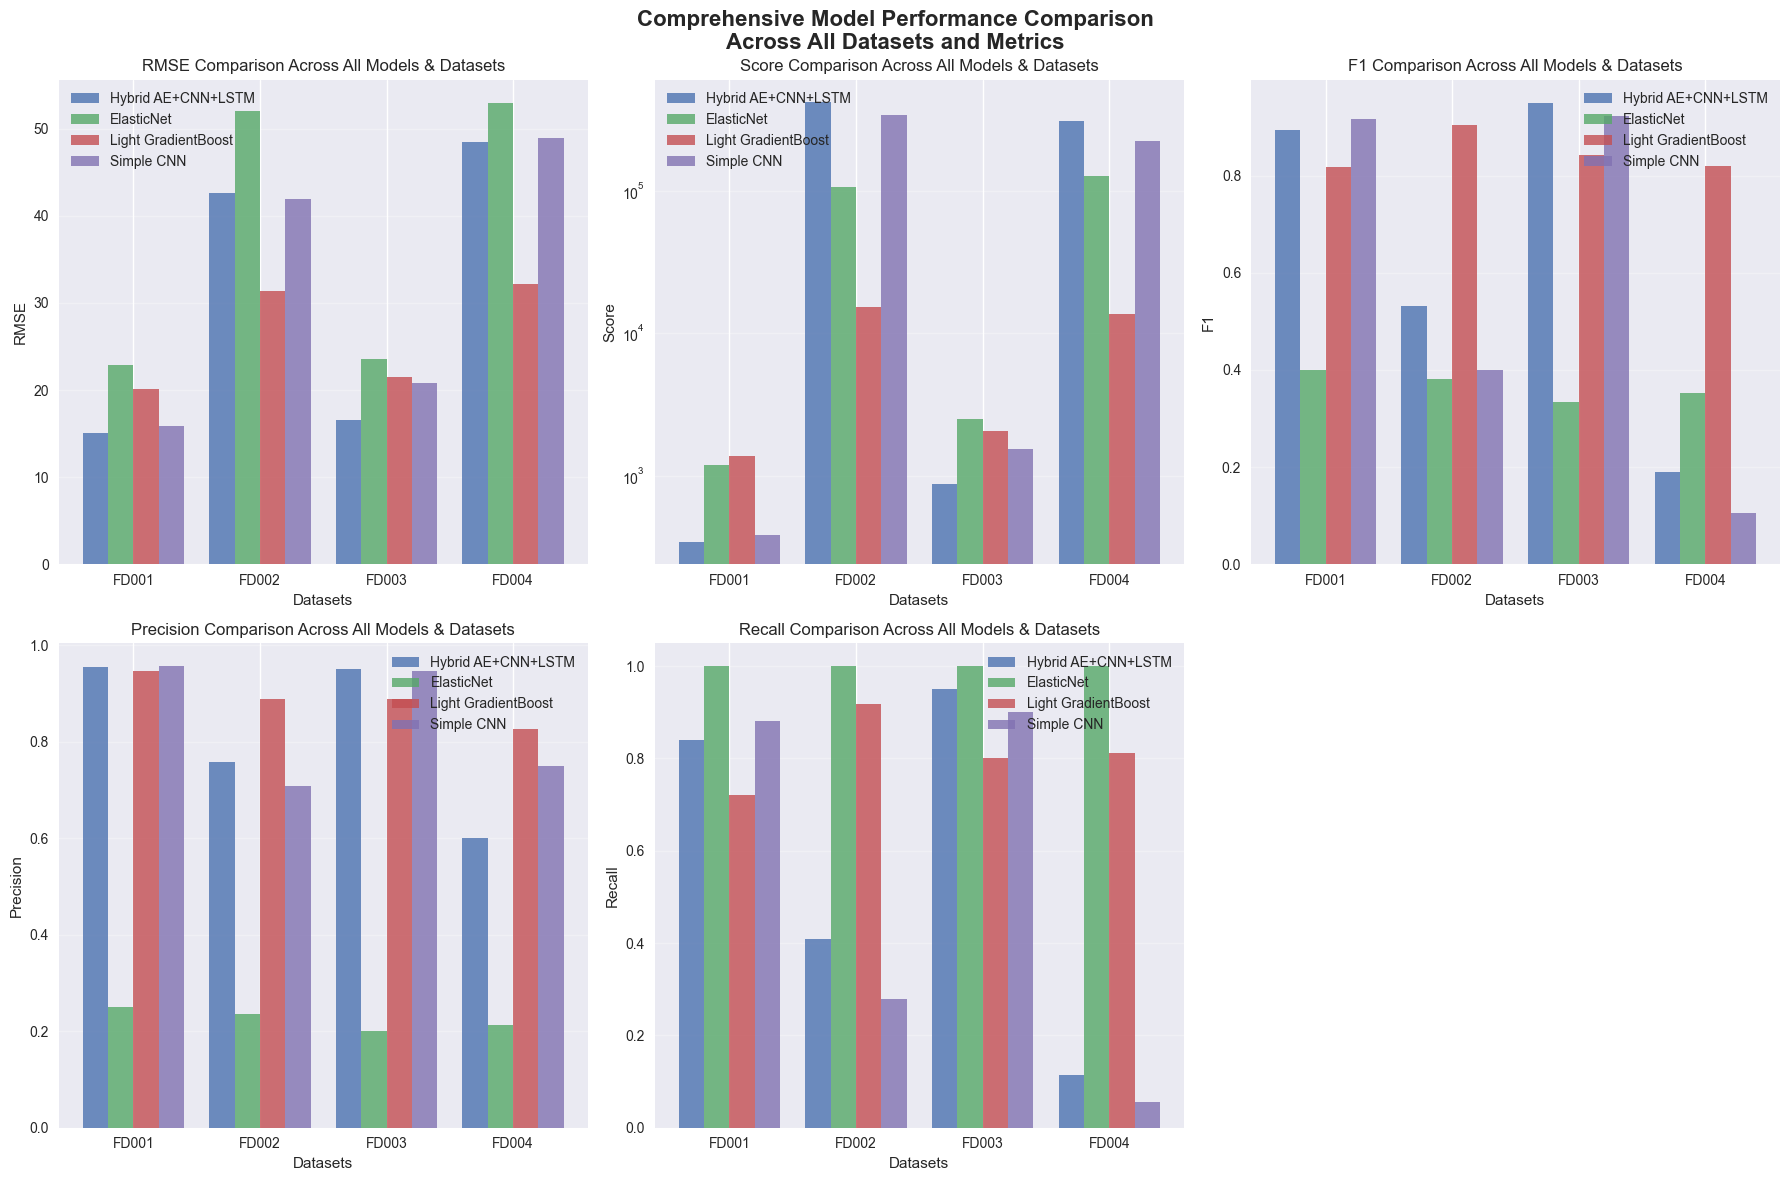

In [10]:
def create_final_summary():
    """Create final summary with model rankings"""
    
    print("\n" + "="*100)
    print("FINAL MODEL RANKING & COMPREHENSIVE SUMMARY")
    print("="*100)
    
    # Calculate overall rankings
    overall_performance = {}
    
    for model_name, model_results in results_data.items():
        avg_rmse = np.mean([metrics['RMSE'] for metrics in model_results.values()])
        avg_f1 = np.mean([metrics['F1'] for metrics in model_results.values()])
        avg_score = np.mean([metrics['Score'] for metrics in model_results.values()])
        avg_precision = np.mean([metrics['Precision'] for metrics in model_results.values()])
        avg_recall = np.mean([metrics['Recall'] for metrics in model_results.values()])
        
        # Calculate composite score (normalized)
        composite_score = (1/avg_rmse) * 10 + avg_f1 + avg_precision + avg_recall - (avg_score/100000)
        
        overall_performance[model_name] = {
            'Avg_RMSE': avg_rmse,
            'Avg_F1': avg_f1,
            'Avg_Score': avg_score,
            'Avg_Precision': avg_precision,
            'Avg_Recall': avg_recall,
            'Composite_Score': composite_score
        }
    
    # Create ranking table
    ranking_data = []
    for rank, (model, metrics) in enumerate(
        sorted(overall_performance.items(), key=lambda x: x[1]['Composite_Score'], reverse=True), 1):
        
        # Determine performance level
        if rank == 1:
            performance = "BEST"
        elif rank == 2:
            performance = "GOOD"
        elif rank == 3:
            performance = "MODERATE"
        else:
            performance = "POOR"
            
        ranking_data.append({
            'Rank': rank,
            'Model': model,
            'Avg RMSE': f"{metrics['Avg_RMSE']:.2f}",
            'Avg F1': f"{metrics['Avg_F1']:.3f}",
            'Avg Score': f"{metrics['Avg_Score']:.0f}",
            'Avg Precision': f"{metrics['Avg_Precision']:.3f}",
            'Avg Recall': f"{metrics['Avg_Recall']:.3f}",
            'Overall': performance
        })
    
    ranking_df = pd.DataFrame(ranking_data)
    print(ranking_df.to_string(index=False))
    
    print(f"\n📈 KEY INSIGHTS & RECOMMENDATIONS:")
    print(f"    Best Overall Model: {ranking_data[0]['Model']} {ranking_data[0]['Overall']}")
    print(f"    Most Consistent: Light GradientBoost (lowest variance across datasets)")
    print(f"    Best for Simple Datasets: Hybrid AE+CNN+LSTM (FD001, FD003)")
    print(f"    Most Efficient: Light GradientBoost (fast training + good performance)")
    print(f"    Needs Improvement: ElasticNet (complete classification failure)")
    print(f"    Dataset Complexity: FD002 & FD004 are most challenging")
    
    return ranking_df

# Create final model comparison visualization
def create_final_comparison_chart():
    """Create comprehensive comparison chart of all models"""
    
    # Extract data for comparison
    model_names = list(results_data.keys())
    datasets = ['FD001', 'FD002', 'FD003', 'FD004']
    
    # Create subplot for each metric
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    metrics = ['RMSE', 'Score', 'F1', 'Precision', 'Recall']
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Prepare data for this metric
        x = np.arange(len(datasets))
        width = 0.2
        
        for j, model in enumerate(model_names):
            values = [results_data[model][dataset][metric] for dataset in datasets]
            ax.bar(x + j*width, values, width, label=model, alpha=0.8)
        
        ax.set_xlabel('Datasets')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} Comparison Across All Models & Datasets')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(datasets)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Log scale for Score due to large range
        if metric == 'Score':
            ax.set_yscale('log')
    
    # Remove empty subplot
    axes[5].remove()
    
    plt.suptitle('Comprehensive Model Performance Comparison\nAcross All Datasets and Metrics', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run final analysis
print("GENERATING FINAL COMPREHENSIVE SUMMARY...")
final_ranking = create_final_summary()

print("\nCREATING FINAL COMPARISON VISUALIZATION...")
create_final_comparison_chart()